
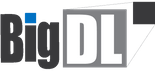
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install BigDL Orca**

You can install the latest release version or latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [2]:
# Install latest release version of bigdl 
# Installing bigdl from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

## **Using Spark Dataframes for Distribtued Deep Learning** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [3]:
import os
import zipfile
import argparse

import numpy as np

from bigdl.dllib.feature.dataset import base
from sklearn.model_selection import train_test_split

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.orca.learn.tf2 import Estimator
from bigdl.orca.data import SharedValue
from pyspark.sql.functions import col
import bigdl.orca.data.pandas

## **Init Orca Context** 

In [4]:
# recommended to set it to True when running BigDL in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
[main] WARN  org.apache.hadoop.util.NativeCodeLoader  - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-03-10 06:30:59,087 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-03-10 06:30:59,100 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-03-10 06:30:59,103 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-03-10 06:30:59,109 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-03-10 06:30:59 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-03-10 06:30:59 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 1



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

22-03-10 06:31:00 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 14
[Thread-4] WARN  org.apache.spark.SparkContext  - Using an existing SparkContext; some configuration may not take effect.
22-03-10 06:31:00 [Thread-4] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity
Successfully got a SparkContext


## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [5]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [6]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

In [8]:
# read csv
spark = OrcaContext.get_spark_session()
df = spark.read.csv(new_rating_files, sep=':', header=True, inferSchema=True).toDF(
  "user", "item", "label", "timestamp")

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

1 6040 1 3952


In [9]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [10]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], 100)

### **Define NCF Model**

In [11]:
def model_creator(config):
    import tensorflow as tf
    from tensorflow import keras
    embedding_size=32
    user = keras.layers.Input(dtype=tf.int32, shape=(None,))
    item = keras.layers.Input(dtype=tf.int32, shape=(None,))
    label = keras.layers.Input(dtype=tf.int32, shape=(None,))

    with tf.name_scope("GMF"):
        user_embed_GMF = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_GMF = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        GMF = keras.layers.Multiply()([user_embed_GMF, item_embed_GMF])

    with tf.name_scope("MLP"):
        user_embed_MLP = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_MLP = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
        layer0_MLP = keras.layers.Dense(units=embedding_size * 3, activation='relu')(interaction)
        layer0_MLP = keras.layers.Dropout(rate=0.6)(layer0_MLP)
        layer1_MLP = keras.layers.Dense(units=embedding_size * 2, activation='relu')(layer0_MLP)
        layer1_MLP = keras.layers.Dropout(rate=0.6)(layer1_MLP)
        layer2_MLP = keras.layers.Dense(units=embedding_size, activation='relu')(layer1_MLP)
        layer2_MLP = keras.layers.Dropout(rate=0.6)(layer2_MLP)
        layer3_MLP = keras.layers.Dense(units=embedding_size // 2, activation='relu')(layer2_MLP)
        layer3_MLP = keras.layers.Dropout(rate=0.6)(layer3_MLP)

    # Concate the two parts together
    with tf.name_scope("concatenation"):
        concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
        outputs = keras.layers.Dense(units=5, activation='softmax')(concatenation)
    
    model = keras.Model(inputs=[user, item], outputs=outputs)
    model.compile(optimizer= "adam",
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

### **Fit with Orca Estimator**

In [12]:
batch_size=1280
epochs=20
model_dir='./'

# create an Estimator
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

stats = est.fit(train_data,
                epochs=epochs,
                batch_size=batch_size,
                feature_cols=['user', 'item'],
                label_cols=['label'],
                steps_per_epoch=800000 // batch_size,
                validation_data=test_data,
                validation_steps = 200000 // batch_size)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
est.save(checkpoint_path)

2022-03-10 06:33:22,679	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-03-10_06-33-17_127570_2555/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-03-10_06-33-17_127570_2555/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-03-10_06-33-17_127570_2555', 'metrics_export_port': 64400, 'node_id': '28dd0a9587e232b7dc5ba767d5d5ddefe932015f461ccfd374e554e6'}


(Worker pid=2899) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(Worker pid=2899) Instructions for updating:
(Worker pid=2899) use distribute.MultiWorkerMirroredStrategy instead
(Worker pid=2899) 2022-03-10 06:33:28.934571: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[Stage 8:>                                                          (0 + 1) / 1]2022-03-10 06:34:08,296	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
(Worker pid=2899) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:195: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute

(Worker pid=2899) Epoch 1/20


(Worker pid=2899) 2022-03-10 06:34:10.061338: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).
(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), d

625/625 [==============================] - ETA: 0s - loss: 1.4278 - accuracy: 0.3533


(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).


625/625 [==============================] - 21s 29ms/step - loss: 1.4278 - accuracy: 0.3533 - val_loss: 1.3137 - val_accuracy: 0.4042
(Worker pid=2899) Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.4116


(Worker pid=2899) 2022-03-10 06:34:48.302392: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 30ms/step - loss: 1.3100 - accuracy: 0.4116 - val_loss: 1.2432 - val_accuracy: 0.4419
(Worker pid=2899) Epoch 3/20
625/625 [==============================] - 18s 29ms/step - loss: 1.2139 - accuracy: 0.4724 - val_loss: 1.2126 - val_accuracy: 0.4584
(Worker pid=2899) Epoch 4/20
624/625 [============================>.] - ETA: 0s - loss: 1.1400 - accuracy: 0.5150


(Worker pid=2899) 2022-03-10 06:35:24.844193: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 30ms/step - loss: 1.1400 - accuracy: 0.5150 - val_loss: 1.2148 - val_accuracy: 0.4554
(Worker pid=2899) Epoch 5/20
625/625 [==============================] - 18s 29ms/step - loss: 1.0901 - accuracy: 0.5406 - val_loss: 1.2293 - val_accuracy: 0.4522
(Worker pid=2899) Epoch 6/20
625/625 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.5578


(Worker pid=2899) 2022-03-10 06:36:02.282344: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 31ms/step - loss: 1.0545 - accuracy: 0.5578 - val_loss: 1.2470 - val_accuracy: 0.4495
(Worker pid=2899) Epoch 7/20
625/625 [==============================] - 19s 30ms/step - loss: 1.0280 - accuracy: 0.5694 - val_loss: 1.2642 - val_accuracy: 0.4468
(Worker pid=2899) Epoch 8/20
625/625 [==============================] - ETA: 0s - loss: 1.0068 - accuracy: 0.5789


(Worker pid=2899) 2022-03-10 06:36:40.454702: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 31ms/step - loss: 1.0068 - accuracy: 0.5789 - val_loss: 1.2808 - val_accuracy: 0.4452
(Worker pid=2899) Epoch 9/20
625/625 [==============================] - 18s 29ms/step - loss: 0.9891 - accuracy: 0.5867 - val_loss: 1.2972 - val_accuracy: 0.4435
(Worker pid=2899) Epoch 10/20
624/625 [============================>.] - ETA: 0s - loss: 0.9743 - accuracy: 0.5932


(Worker pid=2899) 2022-03-10 06:37:17.302733: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 30ms/step - loss: 0.9742 - accuracy: 0.5933 - val_loss: 1.3117 - val_accuracy: 0.4417
(Worker pid=2899) Epoch 11/20
625/625 [==============================] - 19s 30ms/step - loss: 0.9612 - accuracy: 0.5983 - val_loss: 1.3295 - val_accuracy: 0.4416
(Worker pid=2899) Epoch 12/20
625/625 [==============================] - ETA: 0s - loss: 0.9503 - accuracy: 0.6029


(Worker pid=2899) 2022-03-10 06:37:54.095971: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.9503 - accuracy: 0.6029 - val_loss: 1.3451 - val_accuracy: 0.4397
(Worker pid=2899) Epoch 13/20
625/625 [==============================] - 21s 34ms/step - loss: 0.9397 - accuracy: 0.6075 - val_loss: 1.3614 - val_accuracy: 0.4392
(Worker pid=2899) Epoch 14/20
625/625 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.6110


(Worker pid=2899) 2022-03-10 06:38:34.362912: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 31ms/step - loss: 0.9306 - accuracy: 0.6110 - val_loss: 1.3772 - val_accuracy: 0.4388
(Worker pid=2899) Epoch 15/20
625/625 [==============================] - 19s 30ms/step - loss: 0.9227 - accuracy: 0.6140 - val_loss: 1.3882 - val_accuracy: 0.4378
(Worker pid=2899) Epoch 16/20
625/625 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.6172


(Worker pid=2899) 2022-03-10 06:39:11.851997: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 30ms/step - loss: 0.9153 - accuracy: 0.6172 - val_loss: 1.4015 - val_accuracy: 0.4372
(Worker pid=2899) Epoch 17/20
625/625 [==============================] - 19s 30ms/step - loss: 0.9083 - accuracy: 0.6197 - val_loss: 1.4190 - val_accuracy: 0.4367
(Worker pid=2899) Epoch 18/20
624/625 [============================>.] - ETA: 0s - loss: 0.9020 - accuracy: 0.6227


(Worker pid=2899) 2022-03-10 06:39:49.427571: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 19s 30ms/step - loss: 0.9020 - accuracy: 0.6226 - val_loss: 1.4306 - val_accuracy: 0.4364
(Worker pid=2899) Epoch 19/20
625/625 [==============================] - 20s 31ms/step - loss: 0.8965 - accuracy: 0.6244 - val_loss: 1.4456 - val_accuracy: 0.4355
(Worker pid=2899) Epoch 20/20
624/625 [============================>.] - ETA: 0s - loss: 0.8913 - accuracy: 0.6264


(Worker pid=2899) 2022-03-10 06:40:28.764952: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 20s 31ms/step - loss: 0.8914 - accuracy: 0.6263 - val_loss: 1.4576 - val_accuracy: 0.4348


'./NCF.ckpt'

In [13]:
# evaluate with Estimator
stats = est.evaluate(test_data, 
                     feature_cols=['user', 'item'],
                     label_cols=['label'],
                     num_steps=100000 // batch_size)
# est.shutdown()
print(stats)

[Stage 16:>                                                         (0 + 1) / 1]2022-03-10 06:40:41,317	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379


78/78 [==============================] - 0s 3ms/step - loss: 1.4975 - accuracy: 0.4111
[{'validation_loss': 1.4975180625915527, 'validation_accuracy': 0.4110576808452606}]


In [14]:
# stop_orca_context()

In [15]:
pred = est.predict(test_data, feature_cols=['user', 'item'])

(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_4'), name='input_4', description="created by layer 'input_4'"), but it was called on an input with incompatible shape (None,).
(Worker pid=2899) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_5'), name='input_5', description="created by layer 'input_5'"), but it was called on an input with incompatible shape (None,).


 546/6244 [=>............................] - ETA: 18s


[Stage 22:>                                                         (0 + 1) / 1]

 828/6244 [==>...........................] - ETA: 18s


2022-03-10 06:40:54,315	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379


6244/6244 [==============================] - 15s 2ms/step


In [16]:
pred.collect()

[Row(user=1, item=527, label=4, timestamp=978824195, prediction=DenseVector([0.0, 0.0002, 0.067, 0.8027, 0.1301])),
 Row(user=1, item=594, label=3, timestamp=978302268, prediction=DenseVector([0.0, 0.0, 0.0037, 0.9055, 0.0908])),
 Row(user=1, item=595, label=4, timestamp=978824268, prediction=DenseVector([0.0, 0.0019, 0.3281, 0.5459, 0.1241])),
 Row(user=1, item=608, label=3, timestamp=978301398, prediction=DenseVector([0.0, 0.0009, 0.0624, 0.9365, 0.0001])),
 Row(user=1, item=919, label=3, timestamp=978301368, prediction=DenseVector([0.0, 0.0001, 0.0037, 0.1394, 0.8568])),
 Row(user=1, item=1029, label=4, timestamp=978302205, prediction=DenseVector([0.0, 0.0, 0.0004, 0.0864, 0.9132])),
 Row(user=1, item=1097, label=3, timestamp=978301953, prediction=DenseVector([0.0, 0.0008, 0.0191, 0.2545, 0.7256])),
 Row(user=1, item=1270, label=4, timestamp=978300055, prediction=DenseVector([0.0, 0.0002, 0.0135, 0.8771, 0.1092])),
 Row(user=1, item=1287, label=4, timestamp=978302039, prediction=Den

In [17]:
df_pred = pred.toPandas()
df_pred

,user,item,label,timestamp,prediction
0,1,527,4,978824195,"[4.511987917625118e-21, 0.00019451009575277567..."
1,1,594,3,978302268,"[9.928732903004954e-20, 4.270374120096676e-06,..."
2,1,595,4,978824268,"[4.675862426200758e-15, 0.0018955239793285728,..."
3,1,608,3,978301398,"[4.8151424181241964e-08, 0.0009051649831235409..."
4,1,919,3,978301368,"[9.749441505234085e-21, 9.779682295629755e-05,..."
...,...,...,...,...,...
199773,6040,3422,2,956715865,"[0.0016181133687496185, 0.24955721199512482, 0..."
199774,6040,3449,2,956715966,"[0.8009923696517944, 0.17696884274482727, 0.02..."
199775,6040,3471,3,957717463,"[8.466366125503555e-06, 0.025794439017772675, ..."
199776,6040,3504,3,960971857,"[2.0281637262087315e-05, 0.0038264605682343245..."


In [18]:
def f(x):
  x = list(x['prediction'])
  return x.index(max(x))
df_pred['pred_label'] = df_pred.apply(lambda x : f(x), axis = 1)
df_pred

,user,item,label,timestamp,prediction,pred_label
0,1,527,4,978824195,"[4.511987917625118e-21, 0.00019451009575277567...",3
1,1,594,3,978302268,"[9.928732903004954e-20, 4.270374120096676e-06,...",3
2,1,595,4,978824268,"[4.675862426200758e-15, 0.0018955239793285728,...",3
3,1,608,3,978301398,"[4.8151424181241964e-08, 0.0009051649831235409...",3
4,1,919,3,978301368,"[9.749441505234085e-21, 9.779682295629755e-05,...",4
...,...,...,...,...,...,...
199773,6040,3422,2,956715865,"[0.0016181133687496185, 0.24955721199512482, 0...",2
199774,6040,3449,2,956715966,"[0.8009923696517944, 0.17696884274482727, 0.02...",0
199775,6040,3471,3,957717463,"[8.466366125503555e-06, 0.025794439017772675, ...",3
199776,6040,3504,3,960971857,"[2.0281637262087315e-05, 0.0038264605682343245...",4


In [19]:
df_pred = df_pred[df_pred["pred_label"] >= 3]
df_pred.rename(columns = {'item':'movie_id'}, inplace = True)
df_pred

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user,movie_id,label,timestamp,prediction,pred_label
0,1,527,4,978824195,"[4.511987917625118e-21, 0.00019451009575277567...",3
1,1,594,3,978302268,"[9.928732903004954e-20, 4.270374120096676e-06,...",3
2,1,595,4,978824268,"[4.675862426200758e-15, 0.0018955239793285728,...",3
3,1,608,3,978301398,"[4.8151424181241964e-08, 0.0009051649831235409...",3
4,1,919,3,978301368,"[9.749441505234085e-21, 9.779682295629755e-05,...",4
...,...,...,...,...,...,...
199769,6040,3095,3,963271343,"[8.544700904167257e-06, 0.017427733168005943, ...",4
199770,6040,3201,3,957716904,"[1.0779188414744567e-05, 0.00430119875818491, ...",3
199775,6040,3471,3,957717463,"[8.466366125503555e-06, 0.025794439017772675, ...",3
199776,6040,3504,3,960971857,"[2.0281637262087315e-05, 0.0038264605682343245...",4


In [20]:
import pandas as pd
movie_df = pd.read_csv("/content/ml-1m/movies.dat", sep="::", encoding='latin', names=['movie_id', 'name', 'Genre'])
movie_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,movie_id,name,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [21]:
combine_df = df_pred.merge(movie_df, on='movie_id', how='inner')
combine_df

,user,movie_id,label,timestamp,prediction,pred_label,name,Genre
0,1,527,4,978824195,"[4.511987917625118e-21, 0.00019451009575277567...",3,Schindler's List (1993),Drama|War
1,18,527,4,978156146,"[1.0822353857520284e-07, 0.000277719838777557,...",4,Schindler's List (1993),Drama|War
2,33,527,2,978107833,"[4.938773417961784e-05, 0.020441919565200806, ...",4,Schindler's List (1993),Drama|War
3,89,527,4,993955959,"[0.00017702211334835738, 0.0002091014321194961...",3,Schindler's List (1993),Drama|War
4,95,527,3,977628909,"[8.874349788356994e-08, 0.00019087866530753672...",4,Schindler's List (1993),Drama|War
...,...,...,...,...,...,...,...,...
122134,5964,166,3,956998497,"[3.6809451557928696e-05, 0.22666515409946442, ...",3,"Doom Generation, The (1995)",Comedy|Drama
122135,5977,3288,2,957028583,"[0.01299136970192194, 0.025640269741415977, 0....",4,Cotton Mary (1999),Drama
122136,5996,1609,2,956940414,"[0.0011806536931544542, 0.06249266117811203, 0...",3,187 (1997),Drama
122137,6006,2562,4,957573881,"[0.06767389178276062, 0.03621400147676468, 0.4...",4,Bandits (1997),Drama


In [22]:
combine_df.groupby('user').agg({'name':pd.Series.to_list})

,name
user,
1,"[Schindler's List (1993), Snow White and the S..."
2,"[Forrest Gump (1994), Terminator 2: Judgment D..."
3,"[Silence of the Lambs, The (1991), Dances with..."
4,"[Saving Private Ryan (1998), Raiders of the Lo..."
5,"[Wizard of Oz, The (1939), Heat (1995), Cluele..."
...,...
6036,"[Silence of the Lambs, The (1991), Fistful of ..."
6037,"[Fargo (1996), E.T. the Extra-Terrestrial (198..."
6038,"[South Park: Bigger, Longer and Uncut (1999), ..."
